In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def householder_vector(x):
    """
    Вычисляет вектор Хаусхолдера для заданного вектора x.
    Возвращает вектор Хаусхолдера v и коэффициент beta.
    """
    sigma = np.linalg.norm(x[1:])**2
    v = np.copy(x)
    v[0] = 1.0

    if sigma == 0:
        beta = 0
    else:
        mu = np.sqrt(x[0]**2 + sigma)
        if x[0] <= 0:
            v[0] = x[0] - mu
        else:
            v[0] = -sigma / (x[0] + mu)

        beta = 2 * v[0]**2 / (sigma + v[0]**2)
        v = v / v[0]

    return v, beta


def householder_bidiagonalization(A):
    """
    Выполняет бидиагонализацию матрицы A методом Хаусхолдера.

    Parameters:
    -----------
    A : np.ndarray
        Входная матрица размером (m, n), где m >= n.

    Returns:
    --------
    B : np.ndarray
        Бидиагональная матрица (верхняя бидиагональ)
    U_B : np.ndarray
        Ортогональная матрица U
    V_B : np.ndarray
        Ортогональная матрица V
    """
    m, n = A.shape
    assert m >= n, "Матрица должна иметь m >= n"

    # Копируем входную матрицу для модификации
    A_work = A.copy().astype(float)

    # Инициализируем U и V как единичные матрицы
    U = np.eye(m)
    V = np.eye(n)

    for j in range(n):
        # Шаг 1: Обнуляем поддиагональные элементы в столбце j
        if j < m:
            x = A_work[j:, j].copy()
            v, beta = householder_vector(x)

            # Применяем преобразование Хаусхолдера слева
            w = beta * np.dot(v, A_work[j:, j:])
            A_work[j:, j:] -= np.outer(v, w)

            # Сохраняем вектор Хаусхолдера (кроме первого элемента)
            if j < m - 1:
                A_work[j+1:, j] = v[1:]

            # Обновляем U
            w_u = beta * np.dot(U[:, j:], v)
            U[:, j:] -= np.outer(w_u, v)

        # Шаг 2: Обнуляем элементы справа от супердиагонали в строке j
        if j < n - 2:
            x = A_work[j, j+1:].copy()
            v, beta = householder_vector(x)

            # Применяем преобразование Хаусхолдера справа
            w = beta * np.dot(A_work[j:, j+1:], v)
            A_work[j:, j+1:] -= np.outer(w, v)

            # Сохраняем вектор Хаусхолдера (кроме первого элемента)
            A_work[j, j+2:] = v[1:]

            # Обновляем V
            w_v = beta * np.dot(V[:, j+1:], v)
            V[:, j+1:] -= np.outer(w_v, v)

    # Извлекаем бидиагональную матрицу B
    B = np.zeros((m, n))
    for i in range(n):
        # Диагональные элементы
        if i < m:
            B[i, i] = A_work[i, i]
        # Супердиагональные элементы
        if i < n - 1 and i < m:
            B[i, i+1] = A_work[i, i+1]

    return B, U, V


def extract_bidiagonal_from_storage(A_stored):
    """
    Извлекает бидиагональную матрицу из матрицы,
    модифицированной алгоритмом householder_bidiagonalization_inplace.
    """
    m, n = A_stored.shape
    B = np.zeros((m, n))

    for i in range(n):
        if i < m:
            B[i, i] = A_stored[i, i]
        if i < n - 1 and i < m:
            B[i, i+1] = A_stored[i, i+1]

    return B


In [ ]:
np.random.seed(42)
m, n = 5, 3
A = np.random.randn(m, n)
print("Исходная матрица A:")
print(A)
print()

B, U_bdiag, V_bdiag = householder_bidiagonalization(A)
print("Бидиагональная матрица B:")
print(B)
print()

# Проверка: U^T * A * V должно быть равно B (с точностью до ошибок округления)
print("Проверка: ||U^T * A * V - B||_F =",
      np.linalg.norm(U.T @ A @ V - B))

Исходная матрица A:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783]]

Бидиагональная матрица B:
[[2.32662312 0.62242022 0.        ]
 [0.         1.78607532 1.72056009]
 [0.         0.         1.37385284]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]

Проверка: ||U^T * A * V - B||_F = 8.820625845903401e-16


ТЕСТИРОВАНИЕ АЛГОРИТМА ГОЛУБА-КАХАНА

Исходная матрица 5×5:
[[ 0.4967 -0.1383  0.6477  1.523  -0.2342]
 [-0.2341  1.5792  0.7674 -0.4695  0.5426]
 [-0.4634 -0.4657  0.242  -1.9133 -1.7249]
 [-0.5623 -1.0128  0.3142 -0.908  -1.4123]
 [ 1.4656 -0.2258  0.0675 -1.4247 -0.5444]]

------------------------------------------------------------
ШАГ 1: БИДИАГОНАЛИЗАЦИЯ
Бидиагональная матрица B:
[[ 1.7264  0.3369  0.      0.      0.    ]
 [ 0.      2.9662  1.9686  0.      0.    ]
 [ 0.      0.      1.1806  1.1828  0.    ]
 [ 0.      0.      0.      1.0694  1.5958]
 [ 0.      0.      0.      0.     -0.614 ]]

------------------------------------------------------------
ШАГ 2: АЛГОРИТМ ГОЛУБА-КАХАНА

Запуск алгоритма Голуба-Кахана на 50 итераций...
  Итерация   0: норма разности = 2.82e+00
  Итерация  10: норма разности = 1.76e-01
  Итерация  20: норма разности = 2.67e-03
  Итерация  30: норма разности = 3.19e-04
  Итерация  40: норма разности = 3.19e-04

-------------------------------------------

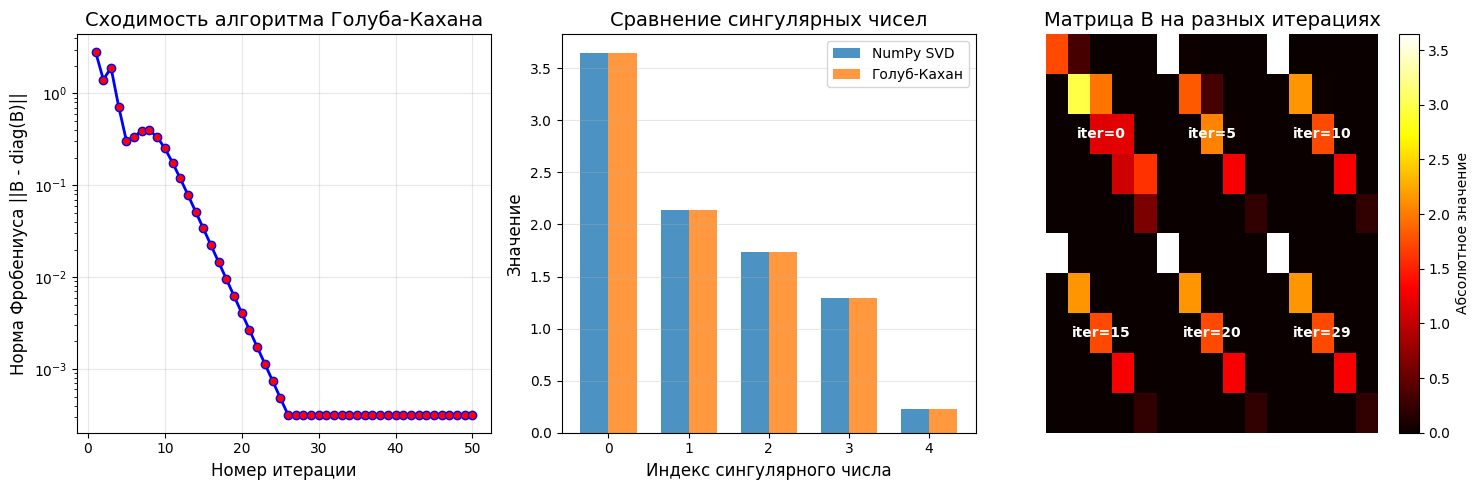


------------------------------------------------------------
ШАГ 5: ПРОВЕРКА СВОЙСТВ

Проверка ортогональности:
  ||UᵀU - I|| = 1.35e-15
  ||VᵀV - I|| = 1.62e-15

Проверка сингулярных чисел:
  Все σᵢ ≥ 0: True
  Минимальное σ: 2.26e-01

------------------------------------------------------------
ТАБЛИЦА ЗНАЧЕНИЙ НОРМ:
Итерация | Норма разности | Уменьшение
----------------------------------------
       1 | 2.8169e+00 | 1.00e+00x
       6 | 3.3648e-01 | 8.37e+00x
      11 | 1.7640e-01 | 1.60e+01x
      16 | 2.2236e-02 | 1.27e+02x
      21 | 2.6651e-03 | 1.06e+03x
      26 | 3.1919e-04 | 8.83e+03x
      31 | 3.1919e-04 | 8.83e+03x
      36 | 3.1919e-04 | 8.83e+03x
      41 | 3.1919e-04 | 8.83e+03x
      46 | 3.1919e-04 | 8.83e+03x

ТЕСТИРОВАНИЕ ЗАВЕРШЕНО


ДОПОЛНИТЕЛЬНЫЙ ТЕСТ: МАТРИЦА С ИЗВЕСТНЫМИ СИНГУЛЯРНЫМИ ЧИСЛАМИ

Тестовая матрица 4×4
Заданные сингулярные числа: [5.  3.  1.  0.1]

Запуск алгоритма Голуба-Кахана на 30 итераций...
  Итерация   0: норма разности = 3.53e+00
  Итераци

In [ ]:
def compute_givens_rotation(a, b):
    """
    Вычисляет параметры вращения Гивенса для обнуления b.

    Returns:
    --------
    c, s : float
        Косинус и синус угла вращения
    r : float
        Норма вектора [a, b]
    """
    if abs(b) < 1e-15:
        return 1.0, 0.0, abs(a)

    r = np.sqrt(a**2 + b**2)
    c = a / r
    s = -b / r
    return c, s, r


def golub_kahan_svd_step(B):
    """
    Одна итерация алгоритма 8.6.1 Голуба-Кахана для бидиагональной матрицы.

    Parameters:
    -----------
    B : np.ndarray
        Бидиагональная матрица размера n×n

    Returns:
    --------
    B_new : np.ndarray
        Обновленная бидиагональная матрица
    U_step : np.ndarray
        Матрица левых вращений
    V_step : np.ndarray
        Матрица правых вращений
    """
    n = B.shape[0]
    B_work = B.copy()
    U_step = np.eye(n)
    V_step = np.eye(n)

    # ШАГ 1: Вычисление сдвига μ (Wilkinson shift)
    if n >= 2:
        b_n1 = B_work[n-2, n-1]  # b_{n-1,n}
        a_n1 = B_work[n-2, n-2]**2 + b_n1**2  # t_{n-1,n-1}
        b_val = b_n1 * B_work[n-1, n-1]        # t_{n-1,n}
        a_n = B_work[n-1, n-1]**2              # t_{n,n}

        # Вычисляем собственные значения 2×2 матрицы [[a_n1, b_val], [b_val, a_n]]
        d = (a_n1 - a_n) / 2.0
        if d >= 0:
            mu = a_n + d - np.sqrt(d**2 + b_val**2)
        else:
            mu = a_n + d + np.sqrt(d**2 + b_val**2)
    else:
        mu = 0

    # ШАГ 2: Начальный вектор (первый столбец T - μI)
    if n >= 1:
        y = B_work[0, 0]**2 - mu      # t_{11} - μ
        if n > 1:
            z = B_work[0, 0] * B_work[0, 1]  # t_{12}
        else:
            z = 0
    else:
        y, z = 0, 0

    # ШАГ 3: Bульдозерное вытеснение (bulge chasing)
    for k in range(n-1):
        # ---------- ВРАЩЕНИЕ СПРАВА (по столбцам) ----------
        if abs(z) > 1e-15:
            r = np.sqrt(y**2 + z**2)
            c = y / r
            s = -z / r
        else:
            c, s = 1.0, 0.0

        # Применяем вращение к столбцам k и k+1
        for i in range(n):
            temp = B_work[i, k]
            B_work[i, k] = c * temp - s * B_work[i, k+1]
            B_work[i, k+1] = s * temp + c * B_work[i, k+1]

        # Обновляем V_step
        for i in range(n):
            temp = V_step[i, k]
            V_step[i, k] = c * temp - s * V_step[i, k+1]
            V_step[i, k+1] = s * temp + c * V_step[i, k+1]

        # Обновляем y, z для левого вращения
        y = B_work[k, k]
        z = B_work[k+1, k]

        # ---------- ВРАЩЕНИЕ СЛЕВА (по строкам) ----------
        if abs(z) > 1e-15:
            r = np.sqrt(y**2 + z**2)
            c = y / r
            s = -z / r
        else:
            c, s = 1.0, 0.0

        # Применяем вращение к строкам k и k+1
        for j in range(n):
            temp = B_work[k, j]
            B_work[k, j] = c * temp - s * B_work[k+1, j]
            B_work[k+1, j] = s * temp + c * B_work[k+1, j]

        # Обновляем U_step
        for i in range(n):
            temp = U_step[i, k]
            U_step[i, k] = c * temp - s * U_step[i, k+1]
            U_step[i, k+1] = s * temp + c * U_step[i, k+1]

        # ---------- ПОДГОТОВКА СЛЕДУЮЩЕГО ШАГА ----------
        if k < n-2:
            y = B_work[k, k+1]
            z = B_work[k, k+2]

    return B_work, U_step, V_step


def fix_svd_signs(D, U, V):
    """
    Исправляет знаки сингулярных чисел.
    Переносит знаки из диагональной матрицы D в матрицы U и V.

    Parameters:
    -----------
    D : np.ndarray
        Диагональная матрица (могут быть отрицательные диагональные элементы)
    U, V : np.ndarray
        Ортогональные матрицы

    Returns:
    --------
    Sigma : np.ndarray
        Диагональная матрица с неотрицательными сингулярными числами
    U_fixed, V_fixed : np.ndarray
        Скорректированные ортогональные матрицы
    """
    n = D.shape[0]

    # Извлекаем диагональные элементы
    diag_vals = np.diag(D).copy()

    # Определяем знаки
    signs = np.sign(diag_vals)
    # Для нулевых элементов знак оставляем положительным
    signs[abs(diag_vals) < 1e-15] = 1

    # Создаем диагональную матрицу знаков
    S = np.diag(signs)

    # Корректируем матрицы
    U_fixed = U @ S
    V_fixed = V @ S

    # Создаем матрицу Σ с неотрицательными сингулярными числами
    Sigma = np.diag(np.abs(diag_vals))

    return Sigma, U_fixed, V_fixed


def golub_kahan_svd_algorithm(B, max_iter=50):
    """
    Полный алгоритм Голуба-Кахана с правильной обработкой знаков.

    Parameters:
    -----------
    B : np.ndarray
        Бидиагональная матрица
    max_iter : int
        Максимальное число итераций

    Returns:
    --------
    Sigma : np.ndarray
        Диагональная матрица с неотрицательными сингулярными числами
    U_total : np.ndarray
        Ортогональная матрица левых сингулярных векторов
    V_total : np.ndarray
        Ортогональная матрица правых сингулярных векторов
    diff_norms : list
        История норм разности B - diag(B)
    """
    n = B.shape[0]
    U_total = np.eye(n)
    V_total = np.eye(n)
    B_work = B.copy()
    diff_norms = []

    print(f"\nЗапуск алгоритма Голуба-Кахана на {max_iter} итераций...")

    for iter_num in range(max_iter):
        # Вычисляем норму разности между B_work и его диагональной частью
        diag_part = np.diag(np.diag(B_work))
        diff_norm = np.linalg.norm(B_work - diag_part, 'fro')
        diff_norms.append(diff_norm)

        # Прогресс каждые 10 итераций
        if iter_num % 10 == 0:
            print(f"  Итерация {iter_num:3d}: норма разности = {diff_norm:.2e}")

        # Одна итерация алгоритма 8.6.1
        B_work, U_step, V_step = golub_kahan_svd_step(B_work)

        # Аккумулируем преобразования
        U_total = U_total @ U_step
        V_total = V_total @ V_step

    # Получаем диагональную матрицу (возможно с отрицательными элементами)
    D = np.diag(np.diag(B_work))

    # Исправляем знаки
    Sigma, U_fixed, V_fixed = fix_svd_signs(D, U_total, V_total)

    return Sigma, U_fixed, V_fixed, diff_norms


def test_and_visualize():
    """
    Тестирование и визуализация сходимости алгоритмов.
    """
    np.random.seed(42)

    # Создаем случайную матрицу
    m, n = 5, 5
    A = np.random.randn(m, n)
    print("="*60)
    print(f"ТЕСТИРОВАНИЕ АЛГОРИТМА ГОЛУБА-КАХАНА")
    print("="*60)
    print(f"\nИсходная матрица {m}×{n}:")
    print(np.round(A, 4))

    # 1. Бидиагонализация
    print("\n" + "-"*60)
    print("ШАГ 1: БИДИАГОНАЛИЗАЦИЯ")
    B, U_bidiag, V_bidiag = householder_bidiagonalization(A)
    print("Бидиагональная матрица B:")
    print(np.round(B, 4))

    # 2. Запускаем алгоритм Голуба-Кахана
    print("\n" + "-"*60)
    print("ШАГ 2: АЛГОРИТМ ГОЛУБА-КАХАНА")
    Sigma_gk, U_gk, V_gk, diff_norms = golub_kahan_svd_algorithm(B, max_iter=50)

    # 3. Проверка с помощью numpy SVD
    print("\n" + "-"*60)
    print("ШАГ 3: ПРОВЕРКА ТОЧНОСТИ")
    U_np, S_np, Vt_np = np.linalg.svd(A, full_matrices=False)
    V_np = Vt_np.T

    # Сингулярные числа из numpy (отсортированы по убыванию)
    print(f"\nСингулярные числа (numpy):    {np.round(S_np, 6)}")

    # Сингулярные числа из нашего алгоритма
    sigma_gk_vals = np.diag(Sigma_gk)
    # Сортируем по убыванию для сравнения
    sort_idx = np.argsort(-sigma_gk_vals)
    sigma_gk_sorted = sigma_gk_vals[sort_idx]
    print(f"Сингулярные числа (Голуб-Кахан): {np.round(sigma_gk_sorted, 6)}")

    # Вычисление ошибок
    error_sigma = np.linalg.norm(sigma_gk_sorted - S_np) / np.linalg.norm(S_np)

    # Проверка разложения
    B_reconstructed = U_gk @ Sigma_gk @ V_gk.T
    reconstruction_error = np.linalg.norm(B - B_reconstructed, 'fro') / np.linalg.norm(B, 'fro')


    print(f"\nМетрики точности:")
    print(f"  Ошибка сингулярных чисел: {error_sigma:.2e}")
    print(f"  Ошибка восстановления  B: {reconstruction_error:.2e}")
    A_reconstructed= U_bidiag @ B_reconstructed @V_bidiag.T
    reconstruction_error_A = np.linalg.norm(A- A_reconstructed, 'fro') / np.linalg.norm(A, 'fro')
    print(f"  Ошибка восстановления  AA: {reconstruction_error_A:.2e}")



    # 4. Визуализация сходимости
    print("\n" + "-"*60)
    print("ШАГ 4: ВИЗУАЛИЗАЦИЯ СХОДИМОСТИ")

    plt.figure(figsize=(15, 5))

    # График 1: Сходимость нормы разности
    plt.subplot(1, 3, 1)
    plt.semilogy(range(1, len(diff_norms) + 1), diff_norms, 'b-o',
                 linewidth=2, markersize=6, markerfacecolor='red')
    plt.xlabel('Номер итерации', fontsize=12)
    plt.ylabel('Норма Фробениуса ||B - diag(B)||', fontsize=12)
    plt.title('Сходимость алгоритма Голуба-Кахана', fontsize=14)
    plt.grid(True, alpha=0.3)


    # График 2: Сравнение сингулярных чисел
    plt.subplot(1, 3, 2)
    x_pos = np.arange(len(S_np))
    width = 0.35

    plt.bar(x_pos - width/2, S_np, width, label='NumPy SVD', alpha=0.8)
    plt.bar(x_pos + width/2, sigma_gk_sorted, width, label='Голуб-Кахан', alpha=0.8)

    plt.xlabel('Индекс сингулярного числа', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.title('Сравнение сингулярных чисел', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # График 3: Визуализация матрицы B на разных этапах
    plt.subplot(1, 3, 3)

    # Собираем B на разных итерациях
    B_iterations = []
    B_temp = B.copy()
    for i in [0, 5, 10, 15, 20, 29]:  # разные моменты времени
        if i > 0:
            for _ in range(i):
                B_temp, _, _ = golub_kahan_svd_step(B_temp)
        B_iterations.append(B_temp)

    # Создаем одну большую матрицу для визуализации
    vis_matrix = np.zeros((n*2, n*3))
    for idx, B_mat in enumerate(B_iterations):
        row = (idx // 3) * n
        col = (idx % 3) * n
        vis_matrix[row:row+n, col:col+n] = np.abs(B_mat)

    plt.imshow(vis_matrix, cmap='hot', aspect='auto')
    plt.colorbar(label='Абсолютное значение')
    plt.title('Матрица B на разных итерациях', fontsize=14)
    plt.axis('off')

    # Добавляем подписи
    iterations = [0, 5, 10, 15, 20, 29]
    for idx, iter_num in enumerate(iterations):
        row = (idx // 3) * n + n//2
        col = (idx % 3) * n + n//2
        plt.text(col, row, f'iter={iter_num}',
                ha='center', va='center',
                color='white', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 5. Детальная проверка свойств
    print("\n" + "-"*60)
    print("ШАГ 5: ПРОВЕРКА СВОЙСТВ")

    # Проверка ортогональности матриц
    orth_U = np.linalg.norm(U_gk.T @ U_gk - np.eye(n), 'fro')
    orth_V = np.linalg.norm(V_gk.T @ V_gk - np.eye(n), 'fro')

    print(f"\nПроверка ортогональности:")
    print(f"  ||UᵀU - I|| = {orth_U:.2e}")
    print(f"  ||VᵀV - I|| = {orth_V:.2e}")


    # Проверка неотрицательности сингулярных чисел
    print(f"\nПроверка сингулярных чисел:")
    print(f"  Все σᵢ ≥ 0: {np.all(sigma_gk_vals >= -1e-10)}")
    print(f"  Минимальное σ: {np.min(sigma_gk_vals):.2e}")

    # 6. Таблица значений норм
    print("\n" + "-"*60)
    print("ТАБЛИЦА ЗНАЧЕНИЙ НОРМ:")
    print("Итерация | Норма разности | Уменьшение")
    print("-" * 40)

    for i in range(0, len(diff_norms), 5):
        if i < len(diff_norms):
            reduction = diff_norms[0] / diff_norms[i] if diff_norms[i] > 0 else float('inf')
            print(f"{i+1:8d} | {diff_norms[i]:.4e} | {reduction:.2e}x")

    # Последняя итерация
    if len(diff_norms) % 5 != 0:
        i = len(diff_norms) - 1
        reduction = diff_norms[0] / diff_norms[i] if diff_norms[i] > 0 else float('inf')
        print(f"{i+1:8d} | {diff_norms[i]:.4e} | {reduction:.2e}x")

    print("\n" + "="*60)
    print("ТЕСТИРОВАНИЕ ЗАВЕРШЕНО")
    print("="*60)

    return A, B, Sigma_gk, U_gk, V_gk, diff_norms


# Запуск теста
if __name__ == "__main__":
    A, B, Sigma_gk, U_gk, V_gk, diff_norms = test_and_visualize()

    # Дополнительная проверка: тест на матрице с известными сингулярными числами
    print("\n\n" + "="*60)
    print("ДОПОЛНИТЕЛЬНЫЙ ТЕСТ: МАТРИЦА С ИЗВЕСТНЫМИ СИНГУЛЯРНЫМИ ЧИСЛАМИ")
    print("="*60)

    # Создаем матрицу с контролируемыми сингулярными числами
    np.random.seed(123)
    n_test = 4
    U_test = np.random.randn(n_test, n_test)
    U_test, _ = np.linalg.qr(U_test)  # Делаем ортогональной

    V_test = np.random.randn(n_test, n_test)
    V_test, _ = np.linalg.qr(V_test)  # Делаем ортогональной

    # Задаем сингулярные числа
    sigma_test = np.array([5.0, 3.0, 1.0, 0.1])
    Sigma_test = np.diag(sigma_test)

    # Создаем тестовую матрицу
    A_test = U_test @ Sigma_test @ V_test.T

    print(f"\nТестовая матрица {n_test}×{n_test}")
    print(f"Заданные сингулярные числа: {sigma_test}")

    # Применяем наш алгоритм
    B_test, _, _ = householder_bidiagonalization(A_test)
    Sigma_test_gk, U_test_gk, V_test_gk, _ = golub_kahan_svd_algorithm(B_test, max_iter=30)

    sigma_test_gk_vals = np.diag(Sigma_test_gk)
    sort_idx = np.argsort(-sigma_test_gk_vals)
    sigma_test_gk_sorted = sigma_test_gk_vals[sort_idx]

    print(f"\nРезультат нашего алгоритма:")
    print(f"  Полученные σ: {np.round(sigma_test_gk_sorted, 6)}")

    error_test = np.linalg.norm(sigma_test_gk_sorted - sigma_test) / np.linalg.norm(sigma_test)
    print(f"  Ошибка: {error_test:.2e}")

    if error_test < 1e-5:
        print("  ✅ ТЕСТ ПРОЙДЕН: алгоритм корректно находит сингулярные числа")
    else:
        print("  ⚠️ ТЕСТ НЕ ПРОЙДЕН: ошибка слишком велика")